In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import time

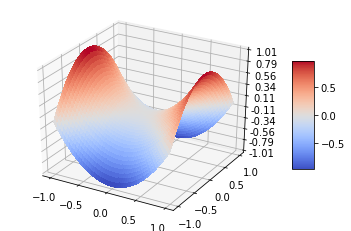

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(X, Y)
rho = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)
Z22map = rho**2*np.cos(2*phi)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z22map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### The derivation see paper

$$
\space \Delta s= 2\cdot A_{2}^{2} / R_{m}^2 = 2 /0.15^2 \cdot A_{2}^{2} = 0.089 \cdot 10^{-6} \cdot A_{2}^{2}
$$


where $A_{2}^{2}$ is the $Z_{2}^{2}$ coefficient in nm, and s is in 1/m


In [3]:
import pandas as pd
from pykat import finesse 
from pykat.commands import *               
from pykat.optics.maps import *
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [4]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

maxtem 8

""")

In [5]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [6]:
# mapwithoutZ22.txt is created in file 'Maps with increasingly astigmatism content(Z22).ipynb', which contains all of the
# other zernike contents besides Z22.
start_time = time.time()
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap1133.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]

HG33map = katHG33.deepcopy()
HG33map.parse("""
        map ETM mapwithoutZ22.txt 
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        pd Pcirc n3
        """)

outHGmap=HG33map.run()

beamHGmap=outHGmap['ccd']
powermap=outHGmap["Pcirc"]
a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
b=np.sum(np.abs(beamHGmap)**2)
c=np.sum(np.abs(beamHGnomap)**2)
purity=np.sqrt(a/(b*c))

loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]

print(f'The HG33 loss with "mapwithoutZ22" applied is {loss}')
print("--- %s mins ---" % ((time.time() - start_time)/60))

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat


The HG33 loss with "mapwithoutZ22" applied is 0.12743213097188877
--- 4.6120382189750675 mins ---


In [22]:
# In order to keep the input beam parameters fixed as a reference
# first need to have a seperate run to find the initial input beam parameter.
HG33kat = katHG33.deepcopy()
HG33kat.parse("""
        bp inputx x q n1
        bp inputy y q n1
        yaxis abs:deg
        """)
HG33kat.noxaxis = True
out = HG33kat.run()
qx = out['inputx']
qy = out['inputy']
print(f'The input beam parameters in the x direction: {qx}, and in the y direction: {qy}')

The input beam parameters in the x direction: (1997.2346000000034+1167.6912580561882j), and in the y direction: (1997.2346000000034+1167.6912580561882j)


In [4]:
# It turns out adding more astigmatism should decrease the radius of curvature in the x direction and increase in the y
# not the other way around
HG33map = katHG33.deepcopy()
s = 1/2679.93
deltas = 0.089e-6*10.12
HG33map.ETM.Rcx = 1/(s+deltas)
HG33map.ETM.Rcy = 1/(s-deltas)
HG33map.parse("""
        gauss* g1 ITM n1 1997.234599999995 1167.6912580562025
        map ETM mapwithoutZ22.txt # additional fixed extra zernikes
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        pd Pcirc n3
        bp inputx x q n1
        """)

outHGmap=HG33map.run()

beamHGmap=outHGmap['ccd']
powermap=outHGmap["Pcirc"]
a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
b=np.sum(np.abs(beamHGmap)**2)
c=np.sum(np.abs(beamHGnomap)**2)
purity=np.sqrt(a/(b*c))

loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]

# The results of fixing the input laser mode and applying Z22 maps are close
print(f'The HG33 loss with the input laser mode fixed is {loss}, and the result of applying Z22 maps is {HG33lossZ22[-1]}')
print(outHGmap['inputx'][0][0])
print("--- %s mins ---" % ((time.time() - start_time)/60))

The HG33 loss with the input laser mode fixed is 0.06525704993954495, and the result of applying Z22 maps is 0.06592176721729481
(1997.2345999999866+1167.6912580561973j)
--- 4.593798168500265 mins ---


In [6]:
# fix the input beam parameters
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap1133.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]

pkHG = parakat()
for value in np.linspace(0.1201,100.1201,44): # value is the Z22 amplitude
    # The Z22 amplitude starts from 0.1201 because the original decomposion shows that the original map has 0.1201nm of 
    # Z22, see file 'Maps with increasingly astigmatism content(Z22).ipynb'
    s = 1/2679.93
    deltas = 0.08889e-6*value
    HG33beam = katHG33.deepcopy()
    HG33beam.ETM.Rcx = 1/(s+deltas)
    HG33beam.ETM.Rcy = 1/(s-deltas)
    HG33beam.parse(f"""
            gauss* g1 ITM n2 -1997.234599999995 1167.6912580562025
            map ETM mapwithoutZ22.txt # additional fixed extra zernikes
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkHG.run(HG33beam)
outHGmap = pkHG.getResults()

HGpurity=[]
HGloss=[]
for i in range(44):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))

    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)

pd.Series(HGloss).to_pickle('pkl/RcHG33lossFixq1.pkl')
pd.Series(HGpurity).to_pickle('pkl/RcHG33purityFixq1.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [7]:
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]

#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap1133.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]

pkHG = parakat()
for value in np.linspace(0.1201,100.1201,44): # value is the Z22 amplitude
    s = 1/2679.93
    deltas = 0.08889e-6*value
    HG33beam = katHG33.deepcopy()
    HG33beam.ETM.Rcx = 1/(s+deltas)
    HG33beam.ETM.Rcy = 1/(s-deltas)
    HG33beam.parse(f"""
#            bp inputx x q n2
            map ETM mapwithoutZ22.txt # additional fixed extra zernikes
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkHG.run(HG33beam)
outHGmap = pkHG.getResults()

HGpurity=[]
HGloss=[]
for i in range(44):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))

    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)

pd.Series(HGloss).to_pickle('pkl/RcHG33loss1.pkl')
pd.Series(HGpurity).to_pickle('pkl/RcHG33purity1.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [16]:
# the input modes with different astigmatism 0.12~10.12
print(f'The original input laser mode is {qx} ')
inputModes = [inputMode[i][0][0] for i in range(7)]
inputModes

[(-1997.1763922884613+1167.7240200797714j),
 (-1996.3672563455646+1168.1790441064425j),
 (-1995.5568206597522+1168.6340598788927j),
 (-1994.745082096756+1169.0890664591693j),
 (-1993.9320375122486+1169.5440629033499j),
 (-1993.1176837517867+1169.9990482614985j),
 (-1992.3020176507168+1170.4540215777556j)]

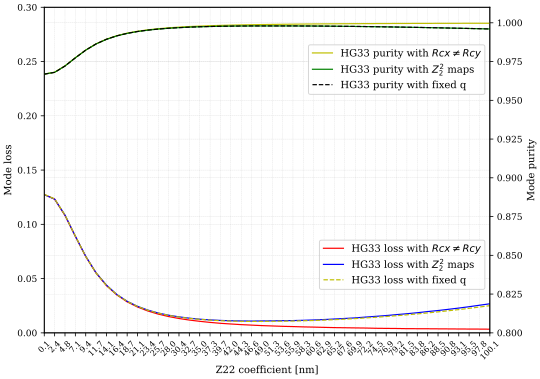

In [3]:
HG33lossRc = pd.read_pickle('pkl/RcHG33loss1.pkl').values
HG33purityRc = pd.read_pickle('pkl/RcHG33purity1.pkl').values

HG33lossZ22 = pd.read_pickle('pkl/Z22HG33loss1.pkl').values
HG33purityZ22 = pd.read_pickle('pkl/Z22HG33purity1.pkl').values

HG33purityRcFixq = pd.read_pickle('pkl/RcHG33purityFixq1.pkl').values
HG33lossRcFixq = pd.read_pickle('pkl/RcHG33lossFixq1.pkl').values

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(HG33lossRc,'r',label=r'HG33 loss with $Rcx \neq Rcy$')
ax.plot(HG33lossZ22,'b',label='HG33 loss with $Z_{2}^{2}$ maps')
ax.plot(HG33lossRcFixq,'y--',label='HG33 loss with fixed q')
xticks = np.around(0.12+np.linspace(0, 100, 44), decimals=1)
ax.set_xlabel("Z22 coefficient [nm]")
ax.set_xticks(range(44))
ax.set_xticklabels(list(xticks),rotation=45, fontsize=8)
ax.set_ylabel("Mode loss")
ax.set_ylim(0,0.3)
ax.legend(bbox_to_anchor=(0.5, -0.2, 0.5, 0.5))

ax2=ax.twinx()
ax2.plot(HG33purityRc,'y',label=r'HG33 purity with $Rcx \neq Rcy$')
ax2.plot(HG33purityZ22,'g',label='HG33 purity with $Z_{2}^{2}$ maps')
ax2.plot(HG33purityRcFixq,'k--',label='HG33 purity with fixed q')
ax2.set_ylim(0.8,1.01)
ax2.set_ylabel("Mode purity")
ax2.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5))
plt.show()
fig.savefig('../astigmaticcavitymode.pdf')